Retrieving SummaryDoc documents: 100%|██████████| 9/9 [00:00<00:00, 132451.71it/s]

Slope: -5.153372344966685
Intercept: 2.9398351762536206
R²: 0.9072158859094158


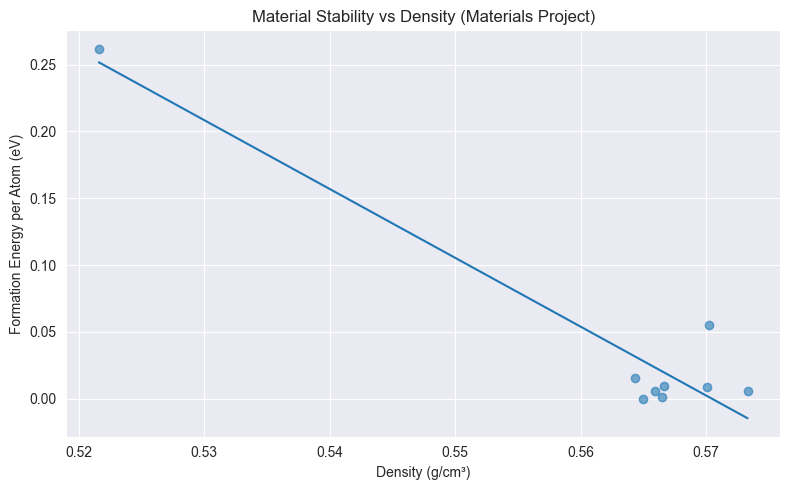

  material_id formula  ev_score
0    mp-10173      Li  0.111111
5       mp-51      Li  0.111111
1  mp-1018134      Li  0.111111
8   mp-976411      Li -0.222222
6   mp-567337      Li -0.333333
4      mp-135      Li -0.666667
3  mp-1103107      Li -0.888889
2  mp-1063005      Li -1.333333
7   mp-604313      Li -1.888889


In [5]:
# FULL MATERIALS PROJECT BATTERY MATERIALS COMPARISON WORKFLOW
# Uses Materials Project API data for EV-relevant analysis

from mp_api.client import MPRester
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# -------------------------------
# 1. Connect to Materials Project
# -------------------------------
API_KEY = "4IeHY5jVcrgiKXNuAo6Jgs7yC0Z3hsli"

with MPRester(API_KEY) as mpr:
    materials = mpr.materials.summary.search(
        chemsys=["Li"],
        fields=[
            "material_id",
            "formula_pretty",
            "band_gap",
            "formation_energy_per_atom",
            "energy_above_hull",
            "density"
        ]
    )

# -------------------------------
# 2. Convert to DataFrame
# -------------------------------
mp_df = pd.DataFrame([{
    "material_id": m.material_id,
    "formula": m.formula_pretty,
    "band_gap": m.band_gap,
    "formation_energy": m.formation_energy_per_atom,
    "energy_above_hull": m.energy_above_hull,
    "density": m.density
} for m in materials])

# Drop rows with missing values
mp_df = mp_df.dropna()

# -------------------------------
# 3. Define EV-relevant target
# (proxy: density vs stability)
# -------------------------------
X = mp_df[['density']]
y = mp_df[['formation_energy']]

# -------------------------------
# 4. Linear regression
# -------------------------------
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
slope = model.coef_[0][0]
intercept = model.intercept_[0]

print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r2)

# -------------------------------
# 5. Plot regression
# -------------------------------
x_line = np.linspace(X.min().values[0], X.max().values[0], 100).reshape(-1, 1)
x_line_df = pd.DataFrame(x_line, columns=['density'])
y_line = model.predict(x_line_df)

plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.6)
plt.plot(x_line, y_line)
plt.xlabel("Density (g/cm³)")
plt.ylabel("Formation Energy per Atom (eV)")
plt.title("Material Stability vs Density (Materials Project)")
plt.tight_layout()
plt.show()

# -------------------------------
# 6. Rank materials for EV relevance
# -------------------------------
mp_df['ev_score'] = (
    mp_df['density'].rank(pct=True)
    - mp_df['formation_energy'].rank(pct=True)
    - mp_df['energy_above_hull'].rank(pct=True)
)

mp_df = mp_df.sort_values('ev_score', ascending=False)

# -------------------------------
# 7. Output top materials
# -------------------------------
top_materials = mp_df[['material_id', 'formula', 'ev_score']].head(50)
print(top_materials)


Higher average voltage → higher pack energy

Higher capacity → longer range

Lower formation energy → stability & safety

Smaller volume change → longer cycle life